# Summary


## Specific

### `tensorboard_x7`

Static GAN network using non-saturating BCE loss.

- First layer: `64 x 20 x 512`.
- Last layer: `64 x 4 x 2048 (4086)`

**Notes:**

- (★) `_posX2` means we multiple `pos_loss` by 2 to account for *neg* and *fake* loss. In general, this looks like a good thing to do.
- (★) Starting with 64-dimensional hidden unit leads to much slower training, no significant increase in the accuracy of the *generator*, but a pretty good *discriminator*.
- Not using instance normalization leads to fast and accurate *discriminator* training but terrible mode collapse in the *generator*. Probably no reason not to do this when training the `ClassifierNet` network.

![](tensorboard/tensorboard_x7/scalars.png)

----

### `tensorboard_x9`

1. Use *pos* vs. *neg* examples to train the adjacency matrix. Fix the adjacency matrix and train the rest of the network using *real* vs. *fake* examples.
2. Make the network contain a *dynamic* number of hidden units. In the last layer, we average the prediction from each of the 4 possible elements.
  - First layer: `64 x 20 x ?`.
  - Last layer: `64 x 1-4 x 2048`

**Notes:**

- Training the adjacency convolutions separately results in much worse accuracy than what is achieved when training the entire network at the same time (`-test_x8` vs. `-text_x7`). Validation accuracy does not suffer as much. Using two-part training leads to much more diversity in the generated sequences, but the plausability of generated sequences quickly plateaus.
- With the dynamic network, we are back to having ~ 1 mode with the generated sequences.
- There is not much difference between averaging features of the last layer and averaging the sigmoid predictions (`_fix3` vs. `_mean_sigmoid`). Not sure why.
- Again, there is terrible mode collapse with the *generator* when it is trained without instance normalization.

![](tensorboard/tensorboard_x9/scalars.png)

----

### `tensorboard_x11`

- Use pytorch 0.4.0.alpha.
- Have multiple sequences in a single "batch".
- Use instance normalization.

**Notes:**

- `gan-permute-seq-0-test_x10-552ee6a-077bb2d` - PyTorch 0.3.1 / one sequence per batch
- `gan-permute-seq-0-0.1.9.dev-077bb2d-test_x11` - PyTorch 0.4.0 / one sequence per batch
- `gan-permute-seq-0-0.1.9.dev-077bb2d-test_x11` - PyTorch 0.4.0 / one sequence per batch
- - PyTorch 0.4.0 / many sequences per batch




----

## General

- Not using instance norm leads to fast training / bad generalization.
- Separate positive and negative training sets makes training much slower (need 15k training steps before reasonable AUC). However, it tends to prevent mode collapse.

# Imports

In [1]:
%run _imports.ipynb

Setting the PACKAGE_VERSION environment variable.
Setting the DOCS_SECRET_KEY environment variable.
Setting the PYTHON_VERSION environment variable.
Setting the SPARK_MASTER environment variable.
Setting the SPARK_ARGS environment variable.
Setting the DB_TYPE environment variable.
Setting the DB_PORT environment variable.


2018-03-20 17:25:00.532517


In [2]:
import io

In [3]:
import ipywidgets as widgets
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from IPython.display import display, update_display
from tensorboard.backend.event_processing import event_accumulator
from PIL import Image

/home/kimlab1/strokach/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
import pagnn

# Parameters

In [5]:
NOTEBOOK_NAME = 'tensorboard'
NOTEBOOK_PATH = Path(NOTEBOOK_NAME)

In [6]:
tensorboard_files = sorted(
    Path(
        'train_neural_network/'
        'tensorboard_x9/'
    ).glob('*/*')
)
tensorboard_files

[PosixPath('train_neural_network/tensorboard_x9/gan-0.1.8.dev-permute-seq-0-077bb2d68941861b143d29672419fa36-test_x9_fix3/events.out.tfevents.1521068767.beagle42'),
 PosixPath('train_neural_network/tensorboard_x9/gan-0.1.8.dev-permute-seq-0-077bb2d68941861b143d29672419fa36-test_x9_mean_sigmoid/events.out.tfevents.1521130043.beagle42'),
 PosixPath('train_neural_network/tensorboard_x9/gan-0.1.8.dev-permute-seq-0-077bb2d68941861b143d29672419fa36-test_x9_mean_sigmoid_no_instance_norm/events.out.tfevents.1521129909.beagle42'),
 PosixPath('train_neural_network/tensorboard_x9/gan-0.1.8.dev-permute-seq-0-077bb2d68941861b143d29672419fa36-test_x9_normalize_after_relu/events.out.tfevents.1521142883.beagle42'),
 PosixPath('train_neural_network/tensorboard_x9/gan-0.1.8.dev-permute-seq-0-427af6fd54a839bc027cfdaf227b1f4a-test_x8_separate_pos_real_training/events.out.tfevents.1520985044.beagle42')]

# Tensorboard

In [7]:
SCALARS = {}
IMAGES = {}

for tensorboard_file in tensorboard_files:
    ea = event_accumulator.EventAccumulator(
        tensorboard_file.as_posix(),
        size_guidance={
            'images': 0,
            'scalars': 0,
        },
    )
    ea.Reload()
    
    SCALARS[tensorboard_file.parent.name] = {
        name.replace('checkpoins', 'checkpoints'): pd.DataFrame(ea.Scalars(name))
        for name in ea.Tags()['scalars']
    }

    IMAGES[tensorboard_file.parent.name] = {
        name: [Image.open(io.BytesIO(img.encoded_image_string)) for img in ea.Images(name)]
        for name in ea.Tags()['images']
    }
    
    del ea

# New heading

In [8]:
SCALARS[tensorboard_file.parent.name]['fake_loss'].head()

,wall_time,step,value
0,1.520985e+09,0,0.669647
1,1.520985e+09,10,0.696402
2,1.520985e+09,20,0.710276
3,1.520985e+09,30,0.726641
4,1.520985e+09,40,0.704329


## Scalars

In [9]:
def make_figure(tensorboard_files, axs):
    scalars = [
        ('fake_loss', 0, 1),
        ('g_fake_loss', 0, 6),
        ('neg_loss', 0, 1),
        ('pos_loss', 0, 1),
        ('training_auc', 0.5, 1),
        ('validation_gan_exact_80_1000', 0.5, 1),
        ('validation_protherm-spearman_r', 0, 1),
        ('checkpoints_per_second', 0, 2),
        ('validation_gan_exact_80_1000-blosum62', -1, -0.5),
        ('validation_gan_exact_80_1000-edit', 0.05, 0.1),
    ]
    
    for i, tensorboard_file in enumerate(tensorboard_files):

        for j, (scalar, y_min, y_max) in enumerate(scalars):
            plt.sca(axs[j // 4, j % 4])
            if scalar not in SCALARS[tensorboard_file.parent.name]:
#                 plt.axis('off')
                continue
            
            df = SCALARS[tensorboard_file.parent.name][scalar]

            if 'checkpoin' in scalar:
                df = df.rolling(20).mean()

            plt.plot(df['step'], df['value'], label=f"({df['value'].max():.4f})")
            plt.ylim(y_min, y_max)
            plt.title(scalar)
            plt.legend()

        j += 1
        plt.sca(axs[j // 4, j % 4])
        plt.axis('off')
        
        j += 1
        plt.sca(axs[j // 4, j % 4])
        plt.axis('off')
        plt.plot(0, 0, label=tensorboard_file.parent.name)
        plt.legend(loc='upper right')

In [10]:
sns.set_context('poster')

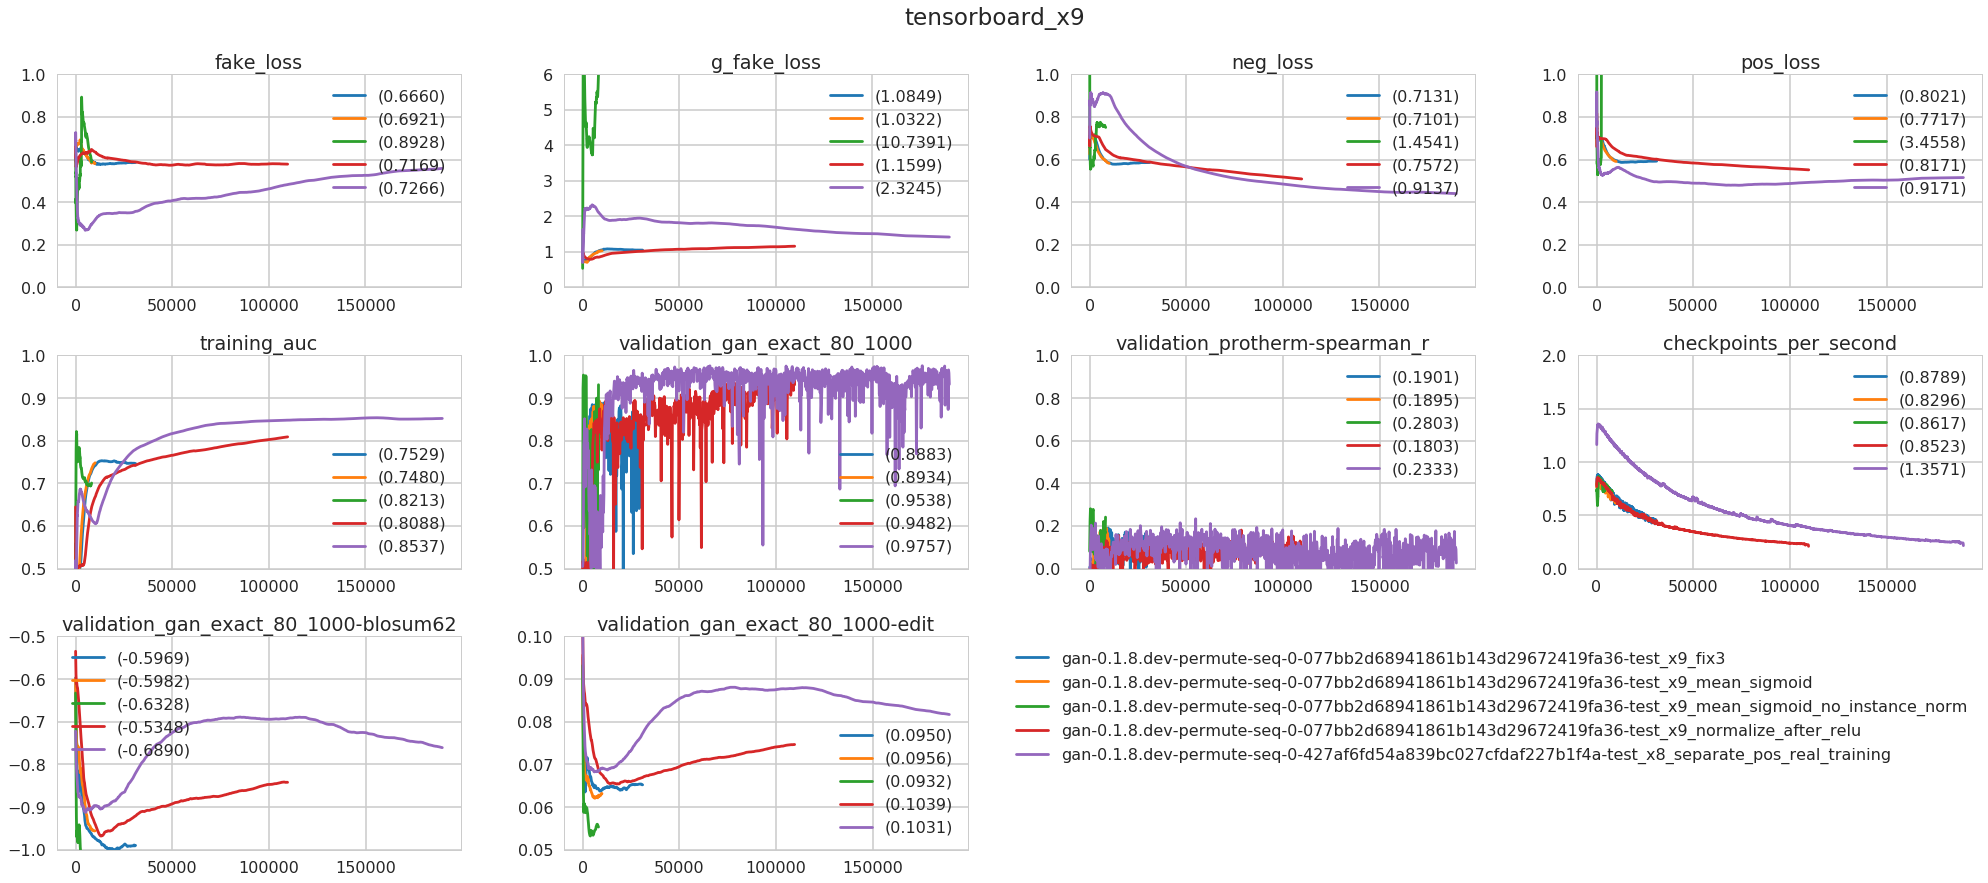

In [11]:
fg, axs = plt.subplots(3, 4, figsize=(28, 12))

make_figure(tensorboard_files, axs)

plt.suptitle(tensorboard_file.parent.parent.name, y=1.03)
plt.tight_layout()

# ----- xxx -----
filename = (
    NOTEBOOK_PATH
    .joinpath(tensorboard_file.parent.parent.name)
    .joinpath('scalars.png')
)
filename.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(filename.as_posix(), dpi=72, bbox_inches='tight')
plt.savefig(filename.with_suffix('.pdf').as_posix(), bbox_inches='tight')

## Images

In [12]:
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 

In [13]:
IMAGE_IDXS = {}

for i, tensorboard_file in enumerate(tensorboard_files):
    if 'validation_gan_exact_80_1000-blosum62' in SCALARS[tensorboard_file.parent.name]:
        df = SCALARS[tensorboard_file.parent.name]['validation_gan_exact_80_1000-blosum62']
    else:
        df = SCALARS[tensorboard_file.parent.name]['validation_gan_exact_80_1000']
        
    burnin = len(df) // 5
    df = df.iloc[burnin:]
    df_max = df[df['value'] == df['value'].max()]
    
    idx = df_max.index[0]
    step = df_max['step'].values[0]
    IMAGE_IDXS[tensorboard_file.parent.name] = (idx, step)

In [14]:
def make_images(tensorboard_files):
    for tensorboard_file in tensorboard_files:
        idx, step = IMAGE_IDXS[tensorboard_file.parent.name]
        img = IMAGES[tensorboard_file.parent.name]['weblogo1'][idx].copy()

        draw = ImageDraw.Draw(img)

        # font = ImageFont.truetype(<font-file>, <font-size>)
        font = ImageFont.truetype("LiberationMono-Regular.ttf", 14)

        text = f"({idx} / {step:,}) " + tensorboard_file.parent.name
        
        x = 45
        y = 5
        w, h = font.getsize(text)
        draw.rectangle((x, y, x + w, y + h), fill='white')

        # draw.text((x, y),"Sample Text",(r,g,b))
        draw.text((x, y), text, (0, 0, 0), font=font)

        filename = (
            NOTEBOOK_PATH
            .joinpath(tensorboard_file.parent.parent.name)
            .joinpath(tensorboard_file.parent.name + '-img.png')
        )
        img.save(filename.as_posix())

In [15]:
make_images(tensorboard_files)

## Image widget

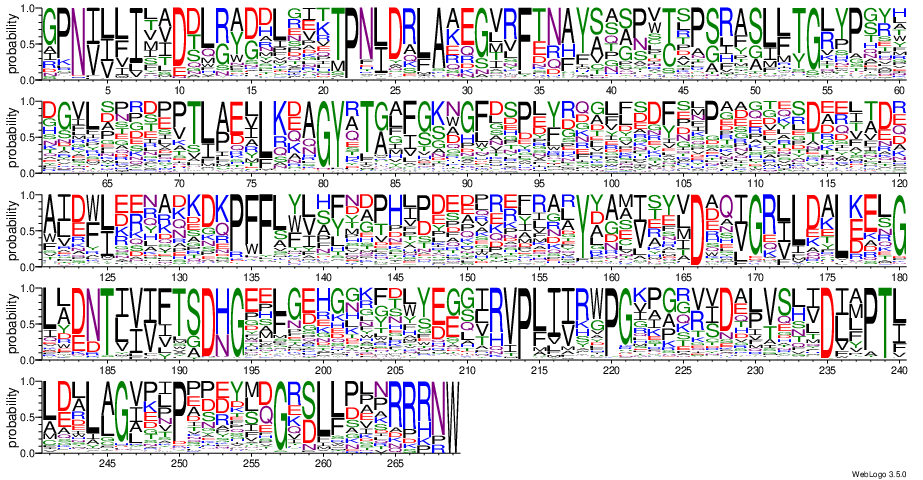

In [20]:
Image.open('validate_trained_network/validation_gan_exact_80_1000_0.png')

In [22]:
# hello world
parent_name = tensorboard_files[4].parent.name
print(parent_name)

images = IMAGES[parent_name]['weblogo1']

s = widgets.IntSlider(
    min=0, max=len(images) - 1, step=1, value=IMAGE_IDXS[parent_name][0], continuous_update=False,
    layout=widgets.Layout(width='100%'),
)

@widgets.interact(i=s)
def image_widget(i):
    display(images[i], display_id=1)

gan-0.1.8.dev-permute-seq-0-427af6fd54a839bc027cfdaf227b1f4a-test_x8_separate_pos_real_training


interactive(children=(IntSlider(value=425, continuous_update=False, description='i', layout=Layout(width='100%'), max=948), Output()), _dom_classes=('widget-interact',))

In [18]:
from PIL import Image